# Setting up Colab environment 

In [1]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-30d8b3k4/polara_8dc7ce9223cb41a5a32c6351af158a42
  Running command git clone -q https://github.com/evfro/polara.git /tmp/pip-install-30d8b3k4/polara_8dc7ce9223cb41a5a32c6351af158a42
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=88531 sha256=fe383f07a8d68a83d02ef6abca6aa589e8b15ed4f613882cfd5e04ce0869b82a
  Stored in directory: /tmp/pip-ephem-wheel-cache-frkhmpsu/wheels/19/88/81/920c4189a6b0b92f19b02f18fcb44ded22ae852f7b09ab2e28
Successfully built polara
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1

# Mount drive and import modules

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# General
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Math methods
from scipy.sparse import csr_matrix

# Data
from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex, leave_one_out

# Models

# Functions

Заголовки матчатся с названиями .py файлов в данном репо

https://github.com/skoltech-ai/Recommender-Systems-Intro-Sber-2022

## dataprep

In [4]:
def transform_indices(data, users, items):
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        idx, idx_map = to_numeric_id(data, field)
        data_index[entity] = idx_map
        data.loc[:, field] = idx
    return data, data_index

def to_numeric_id(data, field):
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map


def matrix_from_data(data, data_description, dtype=None):
    '''
    Converts pandas DataFrame into sparse CSR matrix.
    Assumes data in the DataFrame is alread normalized via `transform_indices`.
    '''
    # get indices of observed data
    user_idx = data[data_description['users']].values
    item_idx = data[data_description['items']].values
    feedback_data = data_description.get('feedback', None)
    if feedback_data is not None:
        feedback = data[feedback_data].values
    else:
        feedback = np.ones(len(user_idx))
    # construct rating matrix
    shape = (data_description['n_users'], data_description['n_items'])
    return csr_matrix((feedback, (user_idx, item_idx)), shape=shape, dtype=dtype)

## evaluation

In [5]:
def downvote_seen_items(scores, data, data_description):
    userid = data_description['users']
    itemid = data_description['items']
    # get indices of observed data
    user_idx = data[userid].values
    item_idx = data[itemid].values
    # downvote scores at the corresponding positions
    user_idx, _ = pd.factorize(user_idx, sort=True)
    seen_idx_flat = np.ravel_multi_index((user_idx, item_idx), scores.shape)
    np.put(scores, seen_idx_flat, -np.inf)


def topn_recommendations(scores, topn=10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations


def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]


def model_evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    
    # Debug
    print(recommended_items.shape)
    print(len(holdout_items))

    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_items = holdout_description['n_items']
    cov = np.unique(recommended_items).size / n_items
    return hr, mrr, cov

# Preparing data

In [6]:
mldata, genres = get_movielens_data(local_file='/content/drive/MyDrive/recSys_AIRI/ml-10M.zip', 
                                    include_time=True, get_genres=True)

metadata = pd.read_csv('/content/drive/MyDrive/recSys_AIRI/meta_info_ml10m.csv', sep=';')

In [7]:
metadata = pd.merge(metadata, genres.drop('genreid', axis=1), on='movieid', how='left').drop_duplicates('movieid')

In [8]:
metadata.head()

,movieid,cast,director,writer,genres,movienm
0,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,NaN,"Animation,Comedy,Family",Toy Story (1995)
5,2,"Robin Williams,Jonathan Hyde,Kirsten Dunst,Bra...",Joe Johnston,NaN,"Adventure,Fantasy,Family",Jumanji (1995)
8,3,"Walter Matthau,Jack Lemmon,Ann-Margret,Sophia ...",Howard Deutch,Mark Steven Johnson,"Romance,Comedy",Grumpier Old Men (1995)
10,4,"Whitney Houston,Angela Bassett,Loretta Devine,...",Forest Whitaker,NaN,"Comedy,Drama,Romance",Waiting to Exhale (1995)
13,5,"Steve Martin,Diane Keaton,Martin Short,Kimberl...",Charles Shyer,NaN,Comedy,Father of the Bride Part II (1995)


In [9]:
meta2 = pd.read_csv('/content/drive/MyDrive/recSys_AIRI/movies_metadata.csv')
meta2 = meta2[meta2.release_date.notnull()].reset_index(drop=True)
meta2.release_date = meta2.release_date.astype(str)
meta2['movienm'] = meta2.title + ' (' + meta2.release_date.apply(lambda x: x[:4]) + ')'

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
# ..., The -> The ...
# split by '('

# Divide and Conquer (Why We Fight)

# and / or

for t in meta2.title:
    if type(t) == str and 'Why We Fight' in t:
        print(t)
        # break

Why We Fight: Prelude to War
Why We Fight
Why We Fight: The Nazis Strike
Why We Fight: The Battle of Britain
Why We Fight: The Battle of Russia
Why We Fight: Divide and Conquer
Why We Fight: The Battle of China
Why We Fight: War Comes to America
Why We Fight: Divide and Conquer


In [11]:
metadata[~metadata.movienm.isin(meta2.movienm)]

,movieid,cast,director,writer,genres,movienm
25,11,"Michael Douglas,Annette Bening,Michael J. Fox,...",Rob Reiner,NaN,"Comedy,Drama,Romance","American President, The (1995)"
69,29,"Ron Perlman,Dominique Pinon,Judith Vittet,Dani...","Jean-Pierre Jeunet,Marc Caro",NaN,"Fantasy,Sci-Fi,Adventure","City of Lost Children, The (CitÃ© des enfants ..."
74,30,"Gong Li,Li Bao-Tian,Wang Xiaoxiao,Li Xuejian,C...",Zhang Yimou,Bi Feiyu,"Drama,Crime",Shanghai Triad (Yao a yao yao dao waipo qiao) ...
77,32,"Bruce Willis,Madeleine Stowe,Brad Pitt,Christo...",Terry Gilliam,NaN,"Sci-Fi,Thriller,Mystery",12 Monkeys (Twelve Monkeys) (1995)
79,33,"Craig Sheffer,Elizabeth McGovern,Tom Hulce,Ken...",Jean-Jacques Annaud,NaN,"Romance,Adventure",Wings of Courage (1995)
...,...,...,...,...,...,...
21528,64959,"Knox Manning,Murray Alper,General Bergeret,Mon...","Frank Capra,Anatole Litvak","Roger Q. Denny,Julius J. Epstein,Philip G. Eps...",Documentary,"Divide and Conquer (Why We Fight, 3) (1943)"
21538,64993,"Kenji Mizuhashi,Yoshimi Kondou,Satomi Hanamura...",Makoto Shinkai,Makoto Shinkai,"Animation,Drama",5 Centimeters per Second (ByÃ´soku 5 senchimÃª...
21543,65001,NaN,Oren Jacoby,"Oren Jacoby,James Carroll",Documentary,Constantine's Sword (2007)
21546,65011,"Vojin Ćetković,Катарина Радивојевић,Dragan Nik...",Zdravko Šotra,NaN,Drama,Zona Zamfirova (2002)


In [12]:
meta2['title']

0                          Toy Story
1                            Jumanji
2                   Grumpier Old Men
3                  Waiting to Exhale
4        Father of the Bride Part II
                    ...             
45374                     Robin Hood
45375            Century of Birthing
45376                       Betrayal
45377               Satan Triumphant
45378                       Queerama
Name: title, Length: 45379, dtype: object

In [13]:
test_timepoint = mldata['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

test_data_ = mldata.query('timestamp >= @test_timepoint')

In [14]:
test_data_.nunique()

userid         5198
movieid        9291
rating           10
timestamp    475010
dtype: int64

In [15]:
train_data_ = mldata.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')

In [16]:
training.userid.nunique()

64680

In [17]:
test_data = reindex(test_data_, data_index['items'])

Filtered 23202 invalid observations.


In [18]:
test_data.nunique()

userid         5132
movieid        8506
rating           10
timestamp    453219
dtype: int64

We sample the last item for each test user.
As all these users are excluded from the training, and training is additionally filtered by timestamp, there will be no "recommendation from future" issue - our model is unaware of future correlations.

## data for final test

In [19]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)

In [20]:
userid = data_index['users'].name
test_users = pd.Index(
    # ensure test users are the same across testing data
    np.intersect1d(
        testset_[userid].unique(),
        holdout_[userid].unique()
    )
)
testset = (
    testset_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout = (
    holdout_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [21]:
print(testset.shape)
print('testset unique users:', testset.userid.nunique())
print(holdout.shape)
print('holdout unique users:', holdout.userid.nunique())

(471670, 4)
testset unique users: 4996
(4996, 4)
holdout unique users: 4996


## data for svd and catboost

In [22]:
training['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

1179203388

In [23]:
valid_timepoint = training['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

cb_data_ = training.query('timestamp >= @valid_timepoint')

svd_data = training.query(
    'userid not in @cb_data_.userid.unique() and timestamp < @test_timepoint'
)

# svd_data, svd_data_index = transform_indices(svd_data_.copy(), 'userid', 'movieid')
# cb_data_ = reindex(cb_data_, svd_data_index['items'])

cb_data, cb_holdout = leave_one_out(
    cb_data_, target='timestamp', sample_top=True, random_state=0
)

In [24]:
userid = data_index['users'].name
cb_users = pd.Index(
    # ensure test users are the same across testing data
    np.intersect1d(
        cb_data[userid].unique(),
        cb_holdout[userid].unique()
    )
)
cb_data = (
    cb_data
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: cb_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
cb_holdout = (
    cb_holdout
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: cb_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [25]:
print(cb_data.shape)
print('cb_data unique users:', cb_data.userid.nunique())
print(cb_holdout.shape)
print('cb_holdout unique users:', cb_holdout.userid.nunique())

(410184, 4)
cb_data unique users: 4048
(4048, 4)
cb_holdout unique users: 4048


## data_description

In [26]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    order = 'timestamp',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)
data_description

{'items': 'movieid',
 'n_items': 9857,
 'n_users': 64680,
 'order': 'timestamp',
 'users': 'userid'}

In [27]:
# svd_data_description = dict(
#     users = svd_data_index['users'].name,
#     items = svd_data_index['items'].name,
#     order = 'timestamp',
#     n_users = len(svd_data_index['users']),
#     n_items = len(svd_data_index['items']),
# )
# svd_data_description

# First stage – SVD implementation

In [28]:
from scipy.sparse.linalg import svds

In [29]:
def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_data(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

In [30]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    n_test_users = data[data_description['users']].nunique()
    test_matrix = matrix_from_data(data, {**data_description, **{'n_users': n_test_users}})
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

In [31]:
def evaluate_svd(params, data, data_description, holdout):
    scores = svd_model_scoring(params, data, data_description)
    downvote_seen_items(scores, data, data_description)
    recs = topn_recommendations(scores, topn=10)
    return model_evaluate(recs, holdout, data_description)

In [32]:
# params = rank_params
# item_factors, sigma = params
# n_test_users = cb_data[data_description['users']].nunique()

# user_idx = cb_data[data_description['users']].values
# item_idx = cb_data[data_description['items']].values
# feedback_data = data_description.get('feedback', None)
# if feedback_data is not None:
#     feedback = cb_data[feedback_data].values
# else:
#     feedback = np.ones(len(user_idx))

# # construct rating matrix
# shape = (len(user_idx), len(item_idx))
# csr_matrix((feedback, (user_idx, item_idx)), shape=shape, dtype=float)

In [33]:
# [b*2**i for i in range(3, 9) for b in [2, 3]]

In [34]:
# svd_tuning_ranks = [b*2**i for i in range(3, 10) for b in [2, 3]]
svd_tuning_ranks = [64]
svd_params = build_svd_model(
    {'rank': max(svd_tuning_ranks)},
    svd_data,
    data_description
)
svd_tuning = {}
for rank in tqdm(svd_tuning_ranks):
    # standard model
    item_factors, singvals = svd_params
    rank_params = item_factors[:, :rank], singvals[:rank]
    svd_tuning[rank] = evaluate_svd(rank_params, cb_data, data_description, cb_holdout)

  0%|          | 0/1 [00:00<?, ?it/s]

(4048, 10)
4048


In [35]:
svd_results = (
    pd.Series(svd_tuning)
    .apply(pd.Series)
    .rename(columns = ['HR', 'MRR', 'COV'].__getitem__)
)

In [36]:
svd_results

,HR,MRR,COV
64,0.07831,0.032143,0.088972


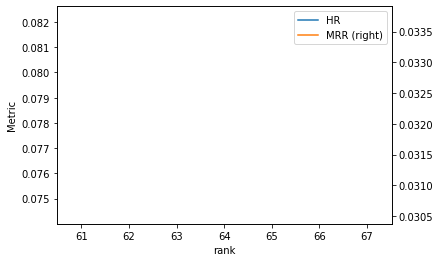

In [37]:
svd_results['HR'].plot(label='HR', legend=True, ylabel='Metric', xlabel='rank')
svd_results['MRR'].plot(secondary_y=True, label='MRR', legend=True);

In [38]:
svd_results.loc[svd_results['HR'].idxmax()]

HR     0.078310
MRR    0.032143
COV    0.088972
Name: 64, dtype: float64

# Second stage – CatBoost implementation

In [39]:
data_description

{'items': 'movieid',
 'n_items': 9857,
 'n_users': 64680,
 'order': 'timestamp',
 'users': 'userid'}

In [40]:
cb_svd_recs = svd_model_scoring((item_factors[:, :64], singvals[:64]), cb_data, data_description)

In [41]:
cb_svd_recs.shape

(4048, 9857)

In [42]:
# item_factors
# embeddings for items

# delete items from history

In [43]:
item_factors[:, :64]

array([[-7.77422723e-02,  2.39338168e-02, -3.12696687e-03, ...,
         1.35442655e-02,  1.34148697e-01,  4.93994621e-02],
       [-4.35285895e-02,  4.68047040e-02, -2.84548569e-02, ...,
         2.76398159e-02,  2.29450497e-02,  1.98816254e-03],
       [-2.45826641e-02,  2.19733275e-02,  2.33920786e-03, ...,
         5.08038390e-03,  5.57212591e-02,  3.40081819e-02],
       ...,
       [-4.61398709e-19,  1.84928855e-18,  2.98761208e-18, ...,
        -1.19148605e-17,  3.03289432e-17,  2.60633326e-17],
       [ 2.22705764e-19, -1.31333776e-18, -2.44563174e-18, ...,
         8.93516070e-18, -2.14790636e-17, -1.84788241e-17],
       [ 2.59708711e-19, -1.33060038e-18, -1.84062154e-18, ...,
         7.68679518e-18, -1.82262611e-17, -1.56332581e-17]])

In [44]:
metadata

,movieid,cast,director,writer,genres,movienm
0,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,NaN,"Animation,Comedy,Family",Toy Story (1995)
5,2,"Robin Williams,Jonathan Hyde,Kirsten Dunst,Bra...",Joe Johnston,NaN,"Adventure,Fantasy,Family",Jumanji (1995)
8,3,"Walter Matthau,Jack Lemmon,Ann-Margret,Sophia ...",Howard Deutch,Mark Steven Johnson,"Romance,Comedy",Grumpier Old Men (1995)
10,4,"Whitney Houston,Angela Bassett,Loretta Devine,...",Forest Whitaker,NaN,"Comedy,Drama,Romance",Waiting to Exhale (1995)
13,5,"Steve Martin,Diane Keaton,Martin Short,Kimberl...",Charles Shyer,NaN,Comedy,Father of the Bride Part II (1995)
...,...,...,...,...,...,...
21553,65088,"Adam Sandler,Keri Russell,Guy Pearce,Courteney...",Adam Shankman,NaN,"Fantasy,Comedy,Family,Romance",Bedtime Stories (2008)
21556,65091,"Clark Gable,William Powell,Myrna Loy,Leo Carri...",W.S. Van Dyke,NaN,"Crime,Drama,Romance",Manhattan Melodrama (1934)
21559,65126,"Anjelica Huston,Kelly Macdonald,Sam Rockwell,C...",Clark Gregg,NaN,"Comedy,Drama",Choke (2008)
21561,65130,"Leonardo DiCaprio,Kate Winslet,Michael Shannon...",Sam Mendes,NaN,"Drama,Romance",Revolutionary Road (2008)


In [45]:
cb_data

,userid,movieid,rating,timestamp
4221,0,581,3.0,1208670024
4435,0,9753,5.0,1208669800
4433,0,9435,2.0,1208669698
4432,0,9392,5.0,1208669977
4431,0,9391,0.5,1208669967
...,...,...,...,...
9994837,4047,6750,3.5,1196056220
9994784,4047,5692,2.5,1185740704
9994914,4047,9522,4.0,1196056504
9994904,4047,9350,3.0,1181567074


In [46]:
recs_for_cb = pd.DataFrame()
recs_for_cb['userid'] = np.repeat(np.sort(cb_data['userid'].unique()), 200) # [i for i in range(cb_data.userid.nunique()) for j in range(200)]
recs_for_cb['movieid'] = topn_recommendations(cb_svd_recs, topn=200).reshape(-1)
recs_for_cb['movie_rank'] = np.tile(np.arange(200), cb_data['userid'].nunique())

In [47]:
cb_data_recs = pd.merge(cb_data, recs_for_cb,
                        on=['userid', 'movieid'], how='right')

In [48]:
cb_data_recs.shape

(809600, 5)

In [49]:
cb_data_recs['target'] = 0
cb_data_recs['target'] += (~cb_data_recs['rating'].isna())

In [50]:
cb_data_recs

,userid,movieid,rating,timestamp,movie_rank,target
0,0,1661,3.0,1.208670e+09,0,1
1,0,640,3.0,1.208670e+09,1,1
2,0,724,NaN,NaN,2,0
3,0,581,3.0,1.208670e+09,3,1
4,0,591,NaN,NaN,4,0
...,...,...,...,...,...,...
809595,4047,6262,NaN,NaN,195,0
809596,4047,6673,NaN,NaN,196,0
809597,4047,6413,NaN,NaN,197,0
809598,4047,290,NaN,NaN,198,0


In [51]:
mldata[mldata.movieid == 9753]

,userid,movieid,rating,timestamp


In [52]:
pd.merge(cb_data_recs.drop(['rating'], axis=1), 
         training[['movieid', 'rating']].drop_duplicates('movieid'),
         on='movieid', how='left').isnull().sum()

userid             0
movieid            0
timestamp     612392
movie_rank         0
target             0
rating             0
dtype: int64

In [53]:
cb_data_recs

,userid,movieid,rating,timestamp,movie_rank,target
0,0,1661,3.0,1.208670e+09,0,1
1,0,640,3.0,1.208670e+09,1,1
2,0,724,NaN,NaN,2,0
3,0,581,3.0,1.208670e+09,3,1
4,0,591,NaN,NaN,4,0
...,...,...,...,...,...,...
809595,4047,6262,NaN,NaN,195,0
809596,4047,6673,NaN,NaN,196,0
809597,4047,6413,NaN,NaN,197,0
809598,4047,290,NaN,NaN,198,0


In [54]:
cb_data_recs.sample(frac=1)

,userid,movieid,rating,timestamp,movie_rank,target
612627,3063,376,3.0,1.208820e+09,27,1
93206,466,148,NaN,NaN,6,0
443345,2216,5514,NaN,NaN,145,0
773781,3868,467,NaN,NaN,181,0
126448,632,1067,5.0,1.206534e+09,48,1
...,...,...,...,...,...,...
545126,2725,1023,NaN,NaN,126,0
100401,502,843,3.5,1.187033e+09,1,1
119151,595,582,NaN,NaN,151,0
632993,3164,1112,NaN,NaN,193,0


In [55]:
metadata

,movieid,cast,director,writer,genres,movienm
0,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,NaN,"Animation,Comedy,Family",Toy Story (1995)
5,2,"Robin Williams,Jonathan Hyde,Kirsten Dunst,Bra...",Joe Johnston,NaN,"Adventure,Fantasy,Family",Jumanji (1995)
8,3,"Walter Matthau,Jack Lemmon,Ann-Margret,Sophia ...",Howard Deutch,Mark Steven Johnson,"Romance,Comedy",Grumpier Old Men (1995)
10,4,"Whitney Houston,Angela Bassett,Loretta Devine,...",Forest Whitaker,NaN,"Comedy,Drama,Romance",Waiting to Exhale (1995)
13,5,"Steve Martin,Diane Keaton,Martin Short,Kimberl...",Charles Shyer,NaN,Comedy,Father of the Bride Part II (1995)
...,...,...,...,...,...,...
21553,65088,"Adam Sandler,Keri Russell,Guy Pearce,Courteney...",Adam Shankman,NaN,"Fantasy,Comedy,Family,Romance",Bedtime Stories (2008)
21556,65091,"Clark Gable,William Powell,Myrna Loy,Leo Carri...",W.S. Van Dyke,NaN,"Crime,Drama,Romance",Manhattan Melodrama (1934)
21559,65126,"Anjelica Huston,Kelly Macdonald,Sam Rockwell,C...",Clark Gregg,NaN,"Comedy,Drama",Choke (2008)
21561,65130,"Leonardo DiCaprio,Kate Winslet,Michael Shannon...",Sam Mendes,NaN,"Drama,Romance",Revolutionary Road (2008)


In [56]:
mldata.nunique()

userid         69878
movieid        10677
rating            10
timestamp    7096905
dtype: int64

In [57]:
genres

,movieid,movienm,genreid
0,1,Toy Story (1995),Adventure
1,1,Toy Story (1995),Animation
2,1,Toy Story (1995),Children
3,1,Toy Story (1995),Comedy
4,1,Toy Story (1995),Fantasy
...,...,...,...
21559,65126,Choke (2008),Comedy
21560,65126,Choke (2008),Drama
21561,65130,Revolutionary Road (2008),Drama
21562,65130,Revolutionary Road (2008),Romance


In [58]:
cb_data_recs

,userid,movieid,rating,timestamp,movie_rank,target
0,0,1661,3.0,1.208670e+09,0,1
1,0,640,3.0,1.208670e+09,1,1
2,0,724,NaN,NaN,2,0
3,0,581,3.0,1.208670e+09,3,1
4,0,591,NaN,NaN,4,0
...,...,...,...,...,...,...
809595,4047,6262,NaN,NaN,195,0
809596,4047,6673,NaN,NaN,196,0
809597,4047,6413,NaN,NaN,197,0
809598,4047,290,NaN,NaN,198,0


AY PART

In [59]:
cb_data_recs = pd.merge(cb_data_recs, metadata[['movieid', 'director', 'genres']], on='movieid', how='left')

In [60]:
cb_data_recs['director'] = cb_data_recs['director'].fillna('None')
cb_data_recs['genres'] = cb_data_recs['genres'].fillna('None')
# cb_data_recs = cb_data_recs[cb_data_recs['timestamp'].notnull()]

In [61]:
import catboost

In [62]:
# rnd = np.random.rand(len(cb_data_recs))

# train_msk = rnd < 0.8
# val_msk = (0.8 <= rnd) & (rnd < 0.9)
# test_msk = rnd >= 0.9

# train_df = cb_data_recs[train_msk]
# val_df = cb_data_recs[val_msk]
# test_df = cb_data_recs[test_msk]

# columns = ['movie_rank', 'director', 'genres']

# train_pool = catboost.Pool(
#     train_df[columns],
#     label=train_df['target'],
#     cat_features=['director', 'genres']
# )

# test_pool = catboost.Pool(
#     test_df[columns],
#     label=test_df['target'],
#     cat_features=['director', 'genres']
# )

# val_pool = catboost.Pool(
#     val_df[columns],
#     label=val_df['target'],
#     cat_features=['director', 'genres']
# )

In [63]:
# cb = catboost.CatBoostClassifier(loss_function='Logloss', iterations=1000, early_stopping_rounds=100)
# cb.fit(train_pool, eval_set=val_pool)

In [64]:
# preds = cb.predict_proba(test_pool)

In [65]:
# preds.shape

In [66]:
# THRESHOLD = 0.5

# pred = preds[:, 1] > THRESHOLD
# is_correct = (pred == test_df['target'])
# is_correct.sum() / len(pred)

RETRAIN SVD & CB ON WHOLE DATASET

In [67]:
# from sklearn.base import BaseEstimator

In [68]:
# class TwoLevelRecommender(BaseEstimator):
#   def __init__(self, svd_rank, data_description):
#     super().__init__()
#     self.svd_rank = svd_rank
#     self.data_description = data_description
#     self.svd_model = None
#     self.cb_model = None

#   def fit(self, X, y):
#     # First level
#     item_factors, singvals = build_svd_model(
#       {'rank': self.svd_rank},
#       X,
#       self.data_description
#     )
#     svd_recs = svd_model_scoring((item_factors, singvals), X, self.data_description)

#     cands = pd.DataFrame()
#     cands['userid'] = np.repeat(np.sort(X['userid'].unique()), 200)
#     cands['movieid'] = topn_recommendations(svd_recs, topn=200).reshape(-1)
#     cands['movie_rank'] = np.tile(np.arange(200), X['userid'].nunique())

#     # Second level
#     data_recs = pd.merge(X, cands, on=['userid', 'movieid'], how='right')
#     data_recs['target'] = 0
#     data_recs['target'] += (~data_recs['rating'].isna())

#     data_recs = pd.merge(data_recs, metadata[['movieid', 'director', 'genres']], on='movieid', how='left')
#     data_recs['director'] = data_recs['director'].fillna('None')
#     data_recs['genres'] = data_recs['genres'].fillna('None')

#     columns = ['movie_rank', 'director', 'genres']
#     pool = catboost.Pool(
#       data_recs[columns],
#       label=data_recs['target'],
#       cat_features=['director', 'genres']
#     )

#     cb = catboost.CatBoostClassifier(loss_function='Logloss', iterations=1000, early_stopping_rounds=100)
#     cb.fit(train_pool, eval_set=val_pool)
    
#     return self

#   def predict(self, X):
#     # Add SVD here
#     preds = cb.predict_proba(test_pool)

#     results = pd.DataFrame()
#     results['userid'] = data_recs['userid']
#     results['movieid'] = data_recs['movieid']
#     results['score'] = preds[:, 1]
    
#     results_agg = results.groupby('userid').apply(lambda row: row.sort_values('score', ascending=False).head(10))
#     full_array = np.array([np.array(x) for x in results_agg.reset_index(drop=True).groupby('userid').movieid.unique().to_numpy()])

#     return full_array

In [69]:
# svd_tuning_ranks = [b*2**i for i in range(3, 10) for b in [2, 3]]
# # svd_tuning_ranks = [64]
# svd_params = build_svd_model(
#     {'rank': max(svd_tuning_ranks)},
#     training,
#     data_description
# )
# svd_tuning = {}
# for rank in tqdm(svd_tuning_ranks):
#     # standard model
#     item_factors, singvals = svd_params
#     rank_params = item_factors[:, :rank], singvals[:rank]
#     svd_tuning[rank] = evaluate_svd(rank_params, testset, data_description, holdout)

In [70]:
# svd_results = (
#     pd.Series(svd_tuning)
#     .apply(pd.Series)
#     .rename(columns = ['HR', 'MRR', 'COV'].__getitem__)
# )

In [71]:
# svd_results

In [72]:
# test_svd_recs = svd_model_scoring((item_factors[:, :64], singvals[:64]), testset, data_description)

In [73]:
# test_svd_recs

In [74]:
# test_cands = pd.DataFrame()
# test_cands['userid'] = np.repeat(np.sort(testset['userid'].unique()), 200) # [i for i in range(cb_data.userid.nunique()) for j in range(200)]
# test_cands['movieid'] = topn_recommendations(test_svd_recs, topn=200).reshape(-1)
# test_cands['movie_rank'] = np.tile(np.arange(200), testset['userid'].nunique())

In [75]:
# test_cands

In [76]:
# testset

In [77]:
# test_data_recs = pd.merge(testset, test_cands,
#                         on=['userid', 'movieid'], how='right')

In [78]:
# test_data_recs['target'] = 0
# test_data_recs['target'] += (~test_data_recs['rating'].isna())

In [79]:
# test_data_recs

In [80]:
# test_data_recs = pd.merge(test_data_recs, metadata[['movieid', 'director', 'genres']], on='movieid', how='left')

# test_data_recs['director'] = test_data_recs['director'].fillna('None')
# test_data_recs['genres'] = test_data_recs['genres'].fillna('None')

In [81]:
# test_data_recs

In [82]:
# columns = ['movie_rank', 'director', 'genres']

# test_pool = catboost.Pool(
#     test_data_recs[columns],
#     label=test_data_recs['target'],
#     cat_features=['director', 'genres']
# )

In [83]:
# preds = cb.predict_proba(test_pool)

In [84]:
# results = pd.DataFrame()
# results['userid'] = test_data_recs['userid']
# results['movieid'] = test_data_recs['movieid']
# results['score'] = preds[:, 1]
# results

In [85]:
# results_agg = results.groupby('userid').apply(lambda row: row.sort_values('score', ascending=False).head(10))

In [86]:
# full_array = np.array([np.array(x) for x in results_agg.reset_index(drop=True).groupby('userid').movieid.unique().to_numpy()])

In [87]:
# full_array.shape

In [88]:
# hr, mrr, cov = model_evaluate(full_array, holdout, data_description)

In [89]:
# hr

In [90]:
from polara.evaluation.pipelines import random_grid

In [91]:
configs = {
    'rank': [b*2**i for i in range(3, 10) for b in [2, 3]]
}

In [98]:
def get_trained_cb(cb_train_df, **kwargs):
  rnd = np.random.rand(len(cb_train_df))
  msk = rnd < 0.9

  train_df = cb_train_df[msk]
  val_df = cb_train_df[~msk]

  columns = ['movie_rank', 'director', 'genres']

  train_pool = catboost.Pool(
      train_df[columns],
      label=train_df['target'],
      cat_features=['director', 'genres']
  )

  val_pool = catboost.Pool(
      val_df[columns],
      label=val_df['target'],
      cat_features=['director', 'genres']
  ) 
  cb = catboost.CatBoostClassifier(loss_function='Logloss',
                                   early_stopping_rounds=100, task_type='GPU', verbose=100, **kwargs)
  cb.fit(train_pool, eval_set=val_pool)

  return cb

In [93]:
def eval_pipeline(X, holdout_, cb_train, svd_rank, **kwargs):
  # First level
  item_factors, singvals = build_svd_model(
    {'rank': svd_rank},
    X,
    data_description
  )
  svd_recs = svd_model_scoring((item_factors, singvals), X, data_description)

  cands = pd.DataFrame()
  cands['userid'] = np.repeat(np.sort(X['userid'].unique()), 200)
  cands['movieid'] = topn_recommendations(svd_recs, topn=200).reshape(-1)
  cands['movie_rank'] = np.tile(np.arange(200), X['userid'].nunique())

  print(f'X: users: {X.userid.nunique()}')
  print(f'cands: users: {cands.userid.nunique()}')

  # Second level
  data_recs = pd.merge(X, cands, on=['userid', 'movieid'], how='right')
  data_recs['target'] = 0
  data_recs['target'] += (~data_recs['rating'].isna())

  data_recs = pd.merge(data_recs, metadata[['movieid', 'director', 'genres']], on='movieid', how='left')
  data_recs['director'] = data_recs['director'].fillna('None')
  data_recs['genres'] = data_recs['genres'].fillna('None')

  cb = get_trained_cb(cb_train, **kwargs)

  columns = ['movie_rank', 'director', 'genres']
  test_pool = catboost.Pool(
      data_recs[columns],
      label=data_recs['target'],
      cat_features=['director', 'genres']
  )

  preds = cb.predict_proba(test_pool)

  results = pd.DataFrame()
  results['userid'] = data_recs['userid']
  results['movieid'] = data_recs['movieid']
  results['score'] = preds[:, 1]

  results_agg = results.groupby('userid').apply(lambda row: row.sort_values('score', ascending=False).head(10))
  full_array = np.array([np.array(x) for x in results_agg.reset_index(drop=True).groupby('userid').movieid.unique().to_numpy()])

  print(f'Unique users in results: {results_agg.userid.nunique()}')

  return model_evaluate(full_array, holdout_, data_description)

In [94]:
print(holdout.userid.nunique())

4996


In [95]:
tuning_res = {}

In [99]:
params, name = random_grid(configs, n=14)
for param in params:
  svd_rank = param[0]

  testset_ = testset.copy()
  holdout_ = holdout.copy()
  cb_data_recs_ = cb_data_recs.copy()

  hr, mrr, cov = eval_pipeline(testset_, holdout_, cb_data_recs_, svd_rank)
  tuning_res[f'rank: {svd_rank}'] = (hr, mrr, cov)
print(tuning_res)

X: users: 4996
cands: users: 4996
Learning rate set to 0.040665
0:	learn: 0.6762452	test: 0.6762280	best: 0.6762280 (0)	total: 61.2ms	remaining: 1m 1s
100:	learn: 0.4865007	test: 0.4865993	best: 0.4865993 (100)	total: 5.35s	remaining: 47.6s
200:	learn: 0.4846861	test: 0.4849068	best: 0.4849068 (200)	total: 9.78s	remaining: 38.9s
300:	learn: 0.4839100	test: 0.4842879	best: 0.4842879 (300)	total: 15.2s	remaining: 35.3s
400:	learn: 0.4833683	test: 0.4838895	best: 0.4838887 (399)	total: 19.6s	remaining: 29.3s
500:	learn: 0.4829988	test: 0.4836648	best: 0.4836648 (500)	total: 23.9s	remaining: 23.8s
600:	learn: 0.4827458	test: 0.4835621	best: 0.4835616 (599)	total: 28.2s	remaining: 18.7s
700:	learn: 0.4824805	test: 0.4834350	best: 0.4834327 (696)	total: 32.5s	remaining: 13.9s
800:	learn: 0.4822619	test: 0.4833425	best: 0.4833425 (800)	total: 36.9s	remaining: 9.16s
900:	learn: 0.4820927	test: 0.4833072	best: 0.4833066 (893)	total: 41.1s	remaining: 4.52s
999:	learn: 0.4819220	test: 0.4832556	b

In [100]:
tuning_res

{'rank: 1024': (0.006405124099279423,
  0.001346235718733717,
  0.17713300192756418),
 'rank: 128': (0.03482786228983187,
  0.0073126755372552015,
  0.06016029217814751),
 'rank: 1536': (0.0038030424339471577,
  0.0008811017067622351,
  0.2235974434412093),
 'rank: 16': (0.05744595676541233, 0.02189847115787868, 0.03763822664096581),
 'rank: 192': (0.02502001601281025, 0.005505515523529934, 0.0685807040681749),
 'rank: 24': (0.05984787830264211, 0.02319816170396635, 0.04118900273917013),
 'rank: 256': (0.02241793434747798, 0.004777472771868288, 0.0763924114842244),
 'rank: 32': (0.06044835868694956, 0.02110259636280453, 0.04697169524196003),
 'rank: 384': (0.01521216973578863,
  0.0032455329342839356,
  0.08988536065740083),
 'rank: 48': (0.05204163330664532, 0.015181828002084207, 0.05123262655980521),
 'rank: 512': (0.012810248198558846,
  0.0027372691804237043,
  0.10652328294612966),
 'rank: 64': (0.048638911128903124,
  0.013550602386671244,
  0.052957289236075886),
 'rank: 768': (

Add more features

In [ ]:
# source_matrix = matrix_from_data(training, data_description)
# _, _, vt = svds(source_matrix, k=16, return_singular_vectors='vh')

In [ ]:
# vt.shape

# Tuning

# Metrics